In [2]:
!pip install keras_tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import keras_tuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import RMSprop, Adagrad, Nadam
import plotly.express as px
import joblib
from tensorflow.keras.models import load_model

# -----------------------------------------------------------------------
# Variáveis Globais
# -----------------------------------------------------------------------

FAIXA_NUMEROS = (-10, 10)  # Faixa de números inteiros usados como entrada (operandos)
TRIALS = 15  # Número de combinações de hiperparâmetros a serem testadas durante a busca
N_SAMPLES = 10000  # Quantidade total de amostras geradas para o dataset
TEST_SIZE = 0.2  # Proporção dos dados reservados para teste
VAL_SIZE = 0.2  # Proporção dos dados reservados para validação
SCALER_TYPE = 'standard'  # Tipo de normalização: 'standard' para StandardScaler ou 'minmax' para MinMaxScaler
INPUT_SHAPE = 6  # Tamanho do vetor de entrada: 2 números + 4 operações codificadas one-hot
EPOCHS = 100  # Número máximo de épocas de treinamento
BATCH_SIZE = 32  # Tamanho do lote usado durante o treinamento
NUM_NEURONS_CHOICES = [128, 256]  # Quantidade de neurônios possíveis por camada densa
OPTIMIZERS = ['rmsprop', 'adagrad', 'nadam']  # Otimizadores testados durante a busca
ACTIVATIONS = ['relu', 'leaky_relu', 'tanh']  # Funções de ativação permitidas
L2_REG_VALUES = [0.001, 0.01]  # Valores possíveis de regularização L2 para evitar overfitting
DROPOUT_RATES = [0.0, 0.1, 0.2]  # Taxas de dropout possíveis entre camadas
LEARNING_RATES = [0.05, 0.1]  # Taxas de aprendizado testadas (ajustadas para valores mais baixos)
NUM_LAYERS_CHOICES = [3, 4, 5]  # Quantidade de camadas densas no modelo
HYPERBAND_FACTOR = 3  # Fator de redução usado no algoritmo Hyperband (impacta alocação de recursos por tentativa)
EARLY_STOPPING_PATIENCE = 5  # Número de épocas sem melhoria para acionar early stopping
TUNING_DIRECTORY = 'tuning_dir'  # Diretório onde os resultados da busca de hiperparâmetros serão salvos
PROJECT_NAME = 'math_mlp'  # Nome do projeto de tuning para identificação
TENSORBOARD_LOG_DIR = "./tuner_logs"  # Diretório onde os logs para o TensorBoard serão armazenados
MODEL_FILENAME = 'melhor_modelo.keras'  # Nome do arquivo onde o melhor modelo será salvo
RANDOM_STATE = 42  # Semente fixa para reprodutibilidade dos resultados

In [4]:
# -----------------------------------------------------------------------
# 1. Preparação e Validação dos Dados
# -----------------------------------------------------------------------

def gerar_dataset(n_samples=N_SAMPLES, faixa_numeros=FAIXA_NUMEROS):
    operacoes = ['+', '-', '*', '/']
    operacoes_dict = {'+': [0, 0, 0, 1], '-': [0, 0, 1, 0], '*': [0, 1, 0, 0], '/': [1, 0, 0, 0]}

    n_por_operacao = n_samples // 4  # Divide igualmente entre as 4 operações
    todos_dados = []

    for op in operacoes:
        numeros = np.random.uniform(faixa_numeros[0], faixa_numeros[1], size=(n_por_operacao, 2))

        if op == '/':
            # Evita divisores próximos de zero
            numeros[:, 1] = np.clip(numeros[:, 1], -0.5, 0.5)
            numeros[:, 1] += np.sign(numeros[:, 1]) * 0.1

        resultados = []
        expressao = []

        for i in range(n_por_operacao):
            num1, num2 = numeros[i]
            try:
                resultado = eval(f"{num1} {op} {num2}")
                expressao_str = f"{num1:.2f} {op} {num2:.2f}"
            except Exception:
                resultado = np.nan
                expressao_str = "Erro de cálculo"

            resultados.append(resultado)
            expressao.append(expressao_str)

        resultados = np.array(resultados)
        mask = ~np.isnan(resultados)
        numeros = numeros[mask]
        resultados = resultados[mask]
        expressao = np.array(expressao)[mask]

        operacoes_one_hot = np.array([operacoes_dict[op]] * len(resultados))

        df_op = pd.DataFrame({
            'num1': numeros[:, 0],
            'num2': numeros[:, 1],
            'operacao_+': operacoes_one_hot[:, 3],
            'operacao_-': operacoes_one_hot[:, 2],
            'operacao_*': operacoes_one_hot[:, 1],
            'operacao_/': operacoes_one_hot[:, 0],
            'resultado': resultados,
            'expressao': expressao
        })

        todos_dados.append(df_op)

    df_final = pd.concat(todos_dados).reset_index(drop=True)
    return df_final

def dividir_dados(df, test_size=TEST_SIZE, val_size=VAL_SIZE, random_state=RANDOM_STATE):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    train_df, val_df = train_test_split(train_df, test_size=val_size / (1 - test_size), random_state=random_state)
    return train_df, val_df, test_df


def normalizar_dados(train_df, val_df, test_df, scaler_type=SCALER_TYPE):
    scaler = StandardScaler() if scaler_type == 'standard' else MinMaxScaler()

    # Garante que não há NaNs antes de escalar
    train_df = train_df.dropna()
    val_df = val_df.dropna()
    test_df = test_df.dropna()

    # Verifique se train_df é vazio após remover NaNs
    if train_df.empty:
        raise ValueError("O DataFrame de treinamento está vazio após a remoção de NaNs.")

    train_scaled = scaler.fit_transform(train_df[['num1', 'num2']])
    val_scaled = scaler.transform(val_df[['num1', 'num2']])
    test_scaled = scaler.transform(test_df[['num1', 'num2']])

    train_df[['num1', 'num2']] = train_scaled
    val_df[['num1', 'num2']] = val_scaled
    test_df[['num1', 'num2']] = test_scaled

    return train_df, val_df, test_df, scaler

In [5]:
# -----------------------------------------------------------------------
# 2. Arquitetura da Rede Neural
# -----------------------------------------------------------------------
def build_model(hp):
    activation = hp.Choice('activation', values=ACTIVATIONS)
    l2_reg = hp.Float('l2_reg', min_value=min(L2_REG_VALUES), max_value=max(L2_REG_VALUES), sampling='log')
    dropout_rate = hp.Choice('dropout_rate', values=DROPOUT_RATES)
    optimizer_name = hp.Choice('optimizer', values=OPTIMIZERS)
    num_neurons = hp.Choice('num_neurons', values=NUM_NEURONS_CHOICES)
    num_layers = hp.Choice('num_layers', values=NUM_LAYERS_CHOICES)
    learning_rate = hp.Float('learning_rate', min_value=min(LEARNING_RATES), max_value=max(LEARNING_RATES), sampling='linear')
    model = keras.Sequential()
    model.add(layers.Input(shape=(INPUT_SHAPE,)))

    for _ in range(num_layers):
        model.add(layers.Dense(num_neurons, kernel_regularizer=keras.regularizers.l2(l2_reg)))
        if activation == 'leaky_relu':
            model.add(layers.LeakyReLU())
        else:
            model.add(layers.Activation(activation))
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(1))

    if optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'adagrad':
        optimizer = Adagrad(learning_rate=learning_rate)
    elif optimizer_name == 'nadam':
        optimizer = Nadam(learning_rate=learning_rate)
    else:
        raise ValueError(f"[ERRO] Otimizador desconhecido: {optimizer_name}")

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [6]:
# -----------------------------------------------------------------------
# 3. Otimização de Hiperparâmetros (com Keras Tuner)
# -----------------------------------------------------------------------

df = gerar_dataset()
train_df, val_df, test_df = dividir_dados(df, random_state=RANDOM_STATE)
try:
    train_df, val_df, test_df, scaler = normalizar_dados(train_df, val_df, test_df, scaler_type=SCALER_TYPE)
except ValueError as e:
    print(f"Erro ao normalizar dados: {e}")
    exit()

# Garantir que não haja valores inf ou NaN nos dados de treinamento
X_train = train_df[['num1', 'num2', 'operacao_+', 'operacao_-', 'operacao_*', 'operacao_/']].values
y_train = train_df['resultado'].values
X_val = val_df[['num1', 'num2', 'operacao_+', 'operacao_-', 'operacao_*', 'operacao_/']].values
y_val = val_df['resultado'].values
X_test = test_df[['num1', 'num2', 'operacao_+', 'operacao_-', 'operacao_*', 'operacao_/']].values
y_test = test_df['resultado'].values

if np.isnan(X_train).any() or np.isinf(X_train).any() or np.isnan(y_train).any() or np.isinf(y_train).any():
    print("Erro: Dados de treinamento contêm valores NaN ou infinito. Verifique a função 'gerar_dataset' e 'normalizar_dados'.")
    exit()
if np.isnan(X_val).any() or np.isinf(X_val).any() or np.isnan(y_val).any() or np.isinf(y_val).any():
    print("Erro: Dados de validação contêm valores NaN ou infinito. Verifique a função 'gerar_dataset' e 'normalizar_dados'.")
    exit()
if np.isnan(X_test).any() or np.isinf(X_test).any() or np.isnan(y_test).any() or np.isinf(y_test).any():
    print("Erro: Dados de teste contêm valores NaN ou infinito. Verifique a função 'gerar_dataset' e 'normalizar_dados'.")
    exit()

tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=TRIALS,
    directory=TUNING_DIRECTORY,
    project_name=PROJECT_NAME,
    overwrite=True,
    max_consecutive_failed_trials=10 ,
    seed=RANDOM_STATE
)

early_stopping_cb = EarlyStopping(monitor='val_mae', patience=EARLY_STOPPING_PATIENCE)
model_checkpoint_cb = ModelCheckpoint(MODEL_FILENAME, save_best_only=True)
tensorboard_cb = TensorBoard(log_dir=TENSORBOARD_LOG_DIR, histogram_freq=0)

tuner.search(X_train, y_train,
             epochs=EPOCHS,
             batch_size=BATCH_SIZE,
             validation_data=(X_val, y_val),
             callbacks=[early_stopping_cb, tensorboard_cb])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Melhores Hiperparâmetros Encontrados:
Função de Ativação: {best_hps.get('activation')}
Taxa de Aprendizado: {best_hps.get('learning_rate')}
Coeficiente de Regularização L2: {best_hps.get('l2_reg')}
Dropout: {best_hps.get('dropout_rate')}
Otimizador: {best_hps.get('optimizer')}
Número de Neurônios por camada: {best_hps.get('num_neurons')}
Número de Camadas: {best_hps.get('num_layers')}
""")

Trial 15 Complete [00h 00m 14s]
val_mae: 9.351812362670898

Best val_mae So Far: 0.8795129656791687
Total elapsed time: 00h 07m 29s

Melhores Hiperparâmetros Encontrados:
Função de Ativação: relu
Taxa de Aprendizado: 0.05972686239665906
Coeficiente de Regularização L2: 0.0026366022252916742
Dropout: 0.2
Otimizador: adagrad
Número de Neurônios por camada: 256
Número de Camadas: 4



In [7]:
df

,num1,num2,operacao_+,operacao_-,operacao_*,operacao_/,resultado,expressao
0,-8.570961,-3.021007,1,0,0,0,-11.591968,-8.57 + -3.02
1,2.493225,3.463686,1,0,0,0,5.956911,2.49 + 3.46
2,-9.259149,-8.022021,1,0,0,0,-17.281171,-9.26 + -8.02
3,-3.465407,-9.785651,1,0,0,0,-13.251058,-3.47 + -9.79
4,7.986249,-4.481818,1,0,0,0,3.504431,7.99 + -4.48
...,...,...,...,...,...,...,...,...
9995,1.265146,-0.600000,0,0,0,1,-2.108577,1.27 / -0.60
9996,-8.918007,0.600000,0,0,0,1,-14.863346,-8.92 / 0.60
9997,1.920694,0.600000,0,0,0,1,3.201157,1.92 / 0.60
9998,5.418757,-0.600000,0,0,0,1,-9.031262,5.42 / -0.60


In [8]:
# Cria uma nova coluna 'tipo_operacao' com base nas colunas binárias
def extrair_operacao(row):
    for op in ['+', '-', '*', '/']:
        if row[f'operacao_{op}'] == 1:
            return op
    return None  # caso não encontre nenhuma, pode ajustar conforme necessidade

df['tipo_operacao'] = df.apply(extrair_operacao, axis=1)

# Agora podemos criar o gráfico com a coluna correta
fig = px.histogram(
    df,
    x='resultado',
    color='tipo_operacao',
    barmode='overlay',
    nbins=80,
    title="Distribuição dos Resultados por Tipo de Operação",
    labels={"resultado": "Resultado", "tipo_operacao": "Operação"}
)

fig.update_layout(
    xaxis_title="Resultado",
    yaxis_title="Frequência",
    legend_title="Operação",
    bargap=0.1,
    xaxis=dict(
        tickmode='linear',
        tick0=-100,
        dtick=10
    )
)

fig.show()


In [9]:
# -----------------------------------------------------------------------
# 4. Treinamento e Avaliação do Melhor Modelo
# -----------------------------------------------------------------------

early_stopping_cb = EarlyStopping(monitor='val_mae', patience=EARLY_STOPPING_PATIENCE)
model_checkpoint_cb = ModelCheckpoint(MODEL_FILENAME, save_best_only=True)
tensorboard_cb = TensorBoard(log_dir=TENSORBOARD_LOG_DIR, histogram_freq=0)

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train,
                          epochs=EPOCHS, batch_size=BATCH_SIZE,
                          validation_data=(X_val, y_val),
                          callbacks=[model_checkpoint_cb, tensorboard_cb])

best_loss, best_mae = best_model.evaluate(X_test, y_test, verbose=0) # evaluate best model on the test data.

print(f'Loss no conjunto de teste: {best_loss:.4f}')
print(f'MAE no conjunto de teste: {best_mae:.4f}')

Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 778.7029 - mae: 12.4868 - val_loss: 40.2829 - val_mae: 3.7076
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 63.9608 - mae: 4.8579 - val_loss: 25.7768 - val_mae: 2.7958
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 36.0596 - mae: 3.5495 - val_loss: 22.3297 - val_mae: 2.4527
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 36.1423 - mae: 3.3170 - val_loss: 10.2423 - val_mae: 1.5454
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 32.7908 - mae: 3.1442 - val_loss: 25.9230 - val_mae: 2.4494
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 36.4832 - mae: 3.0595 - val_loss: 9.9281 - val_mae: 1.2914
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 26.0662 - mae: 2.6984 - val_loss: 10.9701 - val_mae: 1.3173
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 29.4931 - mae: 2.7879 - val_loss: 13.6266 - val_mae: 1.7311
Epoch 9/100
188/188 ━━━━━━━━━━

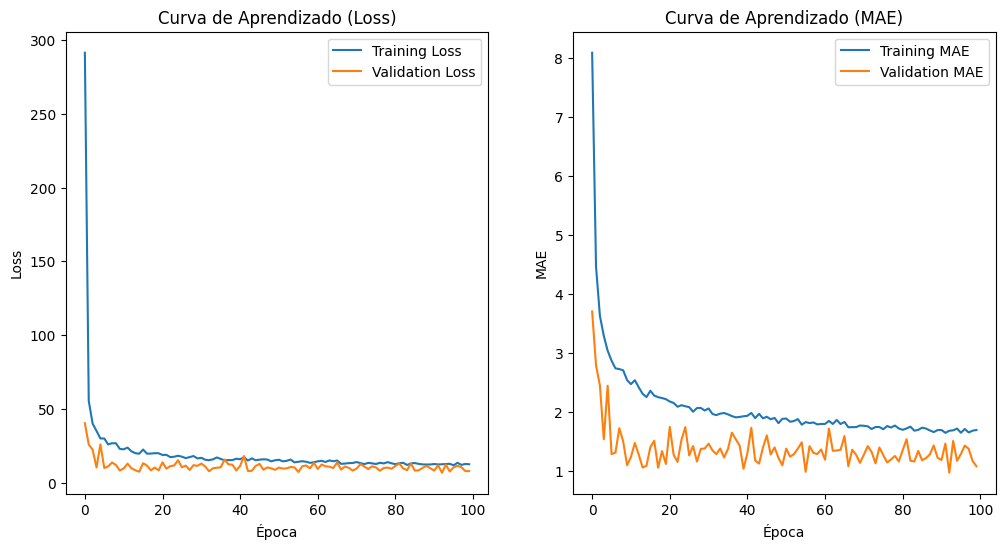

In [10]:
# -----------------------------------------------------------------------
# 5. Análise e Visualização dos Resultados
# -----------------------------------------------------------------------

# Gráfico de Loss e MAE
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Curva de Aprendizado (Loss)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Curva de Aprendizado (MAE)')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()

plt.show()

In [11]:
# -----------------------------------------------------------------------
# Adições para armazenar e comparar modelos
# -----------------------------------------------------------------------

model_results = []
model_histories = {}
model_ids = []
trained_models = {}  # Store the trained models

for trial in tuner.oracle.trials.values():
    model = tuner.hypermodel.build(trial.hyperparameters)
    trained_models[trial.trial_id] = model

    loss, mae = model.evaluate(X_test, y_test, verbose=0)

    # Recuperar as métricas diretamente do trial
    val_mae_metric = trial.metrics.get_history('val_mae')
    val_loss_metric = trial.metrics.get_history('val_loss')

    val_mae = min([entry.value for entry in val_mae_metric]) if val_mae_metric else None
    val_loss = min([entry.value for entry in val_loss_metric]) if val_loss_metric else None


    model_results.append({
        'modelo': trial.trial_id,
        'camadas': trial.hyperparameters.get('num_layers'),
        'neuronios por camada': trial.hyperparameters.get('num_neurons'),
        'otimizador': trial.hyperparameters.get('optimizer'),
        'activation': trial.hyperparameters.get('activation'),
        'learning_rate': trial.hyperparameters.get('learning_rate'),
        'l2_reg': trial.hyperparameters.get('l2_reg'),
        'dropout_rate': trial.hyperparameters.get('dropout_rate'),
        'mae': mae,
        'loss': loss,
        'val_mae': val_mae,
        'val_loss': val_loss
    })

    # Também salva o histórico
    model_histories[trial.trial_id] = [entry.value for entry in val_mae_metric]
    model_ids.append(trial.trial_id)


results_df = pd.DataFrame(model_results)
results_df = results_df.sort_values(by='val_mae', ascending=True)
print("\nResultados de todos os modelos treinados (ordenados por val_mae):\n")
results_df




Resultados de todos os modelos treinados (ordenados por val_mae):



,modelo,camadas,neuronios por camada,otimizador,activation,learning_rate,l2_reg,dropout_rate,mae,loss,val_mae,val_loss
7,07,4,256,adagrad,relu,0.059727,0.002637,0.2,11.613047,320.205963,[0.8795129656791687],[6.770610332489014]
8,08,5,128,adagrad,leaky_relu,0.097998,0.002535,0.0,11.629109,319.842102,[1.0262385606765747],[10.03431510925293]
12,12,3,256,adagrad,leaky_relu,0.070621,0.001108,0.2,11.610787,318.662170,[1.0798259973526],[8.207049369812012]
1,01,5,256,nadam,relu,0.054517,0.003144,0.0,11.615801,321.333313,[1.0822539329528809],[11.844342231750488]
13,13,3,128,adagrad,leaky_relu,0.050076,0.003049,0.2,11.640833,319.622681,[1.0934675931930542],[8.397730827331543]
11,11,5,128,adagrad,tanh,0.095003,0.003273,0.0,11.562594,318.732697,[1.1005302667617798],[15.400235176086426]
10,10,3,256,nadam,leaky_relu,0.085549,0.001073,0.0,11.589520,318.315552,[1.4932044744491577],[12.342312812805176]
6,06,3,128,rmsprop,tanh,0.060184,0.001583,0.2,11.575208,317.651794,[4.91399621963501],[136.28744506835938]
5,05,3,256,rmsprop,tanh,0.074808,0.006523,0.0,11.576374,320.720581,[9.241454124450684],[423.22760009765625]
2,02,4,128,rmsprop,tanh,0.096400,0.001103,0.1,11.611047,318.465729,[9.250090599060059],[284.8829345703125]


In [12]:
# -----------------------------------------------------------------------
# Comparação do Melhor Modelo com os outros
# -----------------------------------------------------------------------

best_model_id = tuner.oracle.get_best_trials(num_trials=1)[0].trial_id
best_model_results = results_df[results_df['modelo'] == best_model_id].iloc[0]

print("\nComparação do Melhor Modelo com os outros:")
print(f"Melhor Modelo ID: {best_model_id}")
print("\nResultados do Melhor Modelo:")
print(best_model_results)

print("\nComparação com outros modelos:")
for model_id in model_ids:
    if model_id != best_model_id:
        model = trained_models[model_id]  # Load the trained model
        loss, mae = model.evaluate(X_test, y_test, verbose=0)  # evaluate that model
        print(f"\nModelo ID: {model_id}")
        print(f"  MAE: {mae:.4f} (Melhor: {best_mae:.4f})")  # compare with best model results
        print(f"  Loss: {loss:.4f} (Melhor: {best_loss:.4f})")


Comparação do Melhor Modelo com os outros:
Melhor Modelo ID: 07

Resultados do Melhor Modelo:
modelo                                    07
camadas                                    4
neuronios por camada                     256
otimizador                           adagrad
activation                              relu
learning_rate                       0.059727
l2_reg                              0.002637
dropout_rate                             0.2
mae                                11.613047
loss                              320.205963
val_mae                 [0.8795129656791687]
val_loss                 [6.770610332489014]
Name: 7, dtype: object

Comparação com outros modelos:

Modelo ID: 00
  MAE: 11.6145 (Melhor: 1.0210)
  Loss: 318.9097 (Melhor: 5.9445)

Modelo ID: 01
  MAE: 11.6158 (Melhor: 1.0210)
  Loss: 321.3333 (Melhor: 5.9445)

Modelo ID: 02
  MAE: 11.6110 (Melhor: 1.0210)
  Loss: 318.4657 (Melhor: 5.9445)

Modelo ID: 03
  MAE: 11.6024 (Melhor: 1.0210)
  Loss: 319.4840 (Me

In [13]:
# Gerar 20 novas equações aleatórias
df_test = gerar_dataset(n_samples=20)

# Salvar a versão original para exibir depois
df_test_original = df_test.copy()

# Normalizar os dados
df_test[['num1', 'num2']] = scaler.transform(df_test[['num1', 'num2']])

# Preparar os dados para o modelo
X_manual = df_test[['num1', 'num2', 'operacao_+', 'operacao_-', 'operacao_*', 'operacao_/']].values

# Fazer previsões
df_test_original['previsto'] = best_model.predict(X_manual).flatten()

# Calcular erro absoluto
df_test_original['erro'] = abs(df_test_original['previsto'] - df_test_original['resultado'])

# Ordenar pelo erro
df_test_ordenado = df_test_original.sort_values(by='erro')

# Exibir os resultados ordenados
print(f"\n{'Expressão':<20} | {'Previsto':>10} | {'Real':>10} | {'Erro Absoluto':>14}")
print("-" * 60)
for _, row in df_test_ordenado.iterrows():
    print(f"{row['expressao']:<20} | {row['previsto']:>10.4f} | {row['resultado']:>10.4f} | {row['erro']:>14.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step

Expressão            |   Previsto |       Real |  Erro Absoluto
------------------------------------------------------------
-4.93 / 0.60         |    -8.1909 |    -8.2178 |         0.0269
1.56 / 0.60          |     2.4893 |     2.6066 |         0.1173
2.77 * -3.30         |    -9.2733 |    -9.1344 |         0.1389
-0.66 / 0.60         |    -0.9339 |    -1.1040 |         0.1701
-3.97 + -8.65        |   -12.4072 |   -12.6234 |         0.2163
1.17 * -3.87         |    -4.2634 |    -4.5145 |         0.2511
6.11 / -0.60         |   -10.4740 |   -10.1791 |         0.2949
5.54 + -0.15         |     4.8760 |     5.3811 |         0.5051
6.31 - -2.23         |     8.0319 |     8.5436 |         0.5117
3.57 + 1.10          |     4.1285 |     4.6639 |         0.5354
2.74 - -0.84         |     2.9945 |     3.5801 |         0.5856
-7.91 / 0.60         |   -13.7761 |   -13.1840 |         0.5921
-8.42 + -2.15        |    -9.5340 |   -10.5690 |         1.0349
3.10

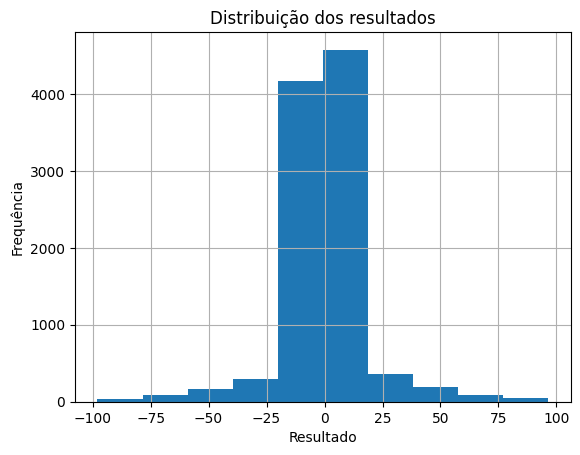

In [14]:
df['resultado'].hist(bins=10)
plt.title("Distribuição dos resultados")
plt.xlabel("Resultado")
plt.ylabel("Frequência")
plt.show()


In [15]:
# Salva o modelo treinado (caso ainda não tenha salvo com ModelCheckpoint)
best_model.save("melhor_modelo.keras")  # Arquivo HDF5/Keras

# Salva o scaler usado para normalizar os dados
joblib.dump(scaler, 'scaler.pkl')

print("Modelo e scaler exportados com sucesso.")


Modelo e scaler exportados com sucesso.


In [20]:
# Carregar o modelo treinado
modelo_carregado = load_model("melhor_modelo.keras")

# Carregar o scaler usado na normalização
scaler_carregado = joblib.load('scaler.pkl')

print("Modelo e scaler carregados com sucesso.")

Modelo e scaler carregados com sucesso.


In [21]:
# Gerar 20 novas equações aleatórias
df_test = gerar_dataset(n_samples=100)

# Salvar a versão original para exibir depois
df_test_original = df_test.copy()

# Normalizar os dados
df_test[['num1', 'num2']] = scaler_carregado.transform(df_test[['num1', 'num2']])

# Preparar os dados para o modelo
X_manual = df_test[['num1', 'num2', 'operacao_+', 'operacao_-', 'operacao_*', 'operacao_/']].values

# Fazer previsões
df_test_original['previsto'] = modelo_carregado.predict(X_manual).flatten()

# Calcular erro absoluto
df_test_original['erro'] = abs(df_test_original['previsto'] - df_test_original['resultado'])

# Ordenar pelo erro
df_test_ordenado = df_test_original.sort_values(by='erro')

# Exibir os resultados ordenados
print(f"\n{'Expressão':<20} | {'Previsto':>10} | {'Real':>10} | {'Erro Absoluto':>14}")
print("-" * 60)
for _, row in df_test_ordenado.iterrows():
    print(f"{row['expressao']:<20} | {row['previsto']:>10.4f} | {row['resultado']:>10.4f} | {row['erro']:>14.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Expressão            |   Previsto |       Real |  Erro Absoluto
------------------------------------------------------------
-4.26 - -0.76        |    -3.5037 |    -3.5035 |         0.0002
2.88 + -3.49         |    -0.6013 |    -0.6108 |         0.0094
9.34 * -8.15         |   -76.1449 |   -76.1222 |         0.0227
7.23 + 9.17          |    16.3832 |    16.4078 |         0.0246
7.06 - -6.51         |    13.5371 |    13.5714 |         0.0343
5.60 + 7.28          |    12.9181 |    12.8805 |         0.0375
-4.10 - 2.02         |    -6.0878 |    -6.1275 |         0.0396
5.71 + 0.91          |     6.5645 |     6.6201 |         0.0555
-0.30 + 1.36         |     1.0000 |     1.0571 |         0.0571
-7.73 * 4.00         |   -30.9585 |   -30.8979 |         0.0606
-2.74 + -3.59        |    -6.3948 |    -6.3313 |         0.0635
4.02 - -1.56         |     5.5030 |     5.5802 |         0.0772
-7.89 / -0.60        |    13.0602 |    13.1418 |         0.0816
3.99

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


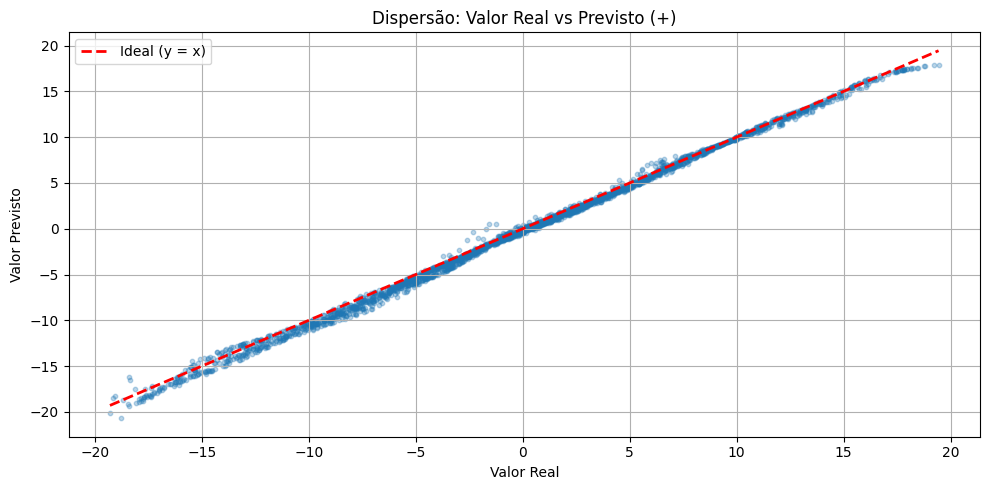

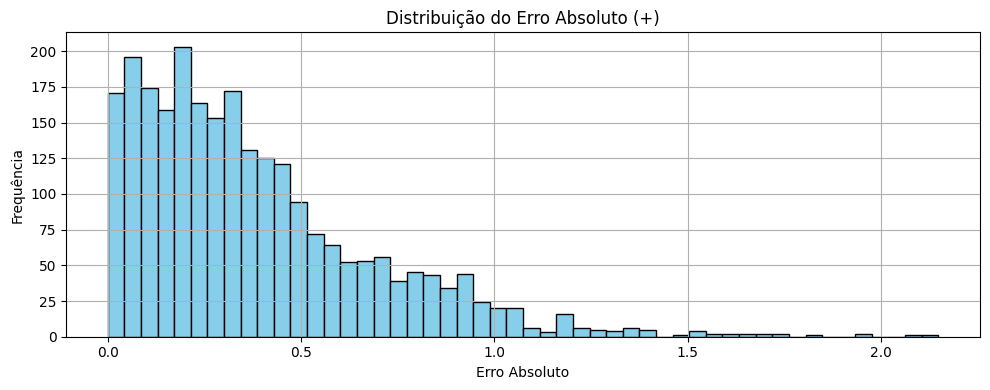

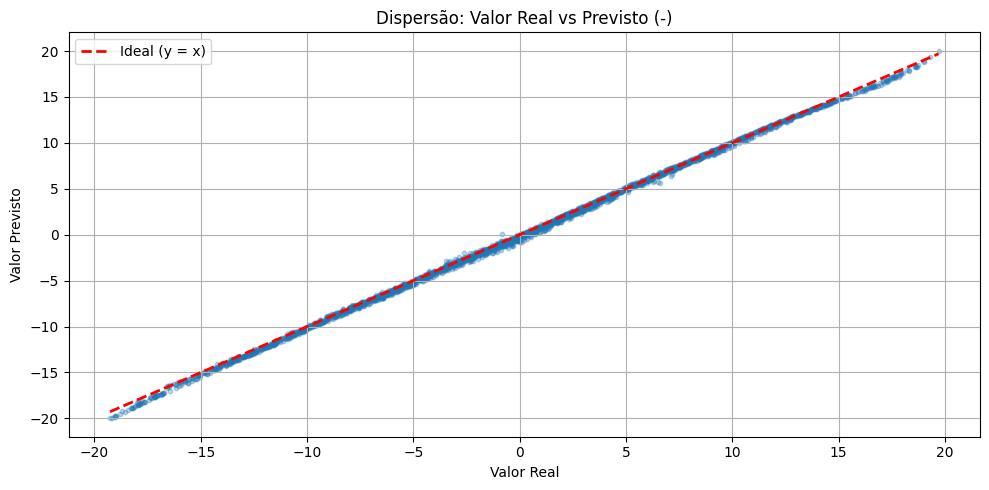

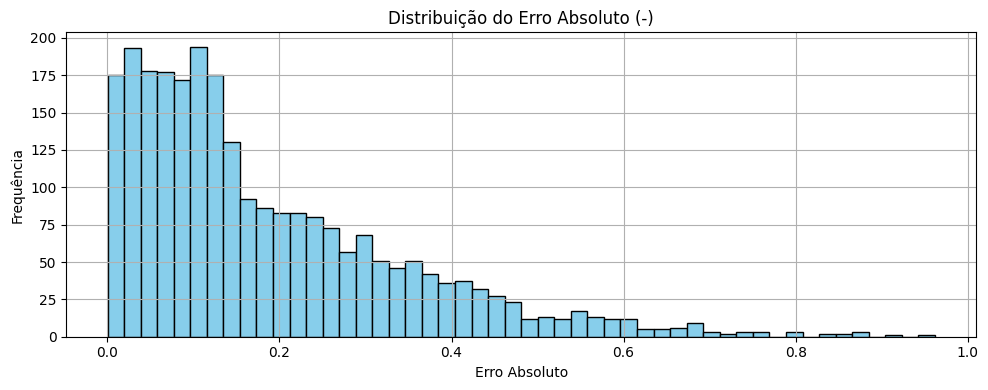

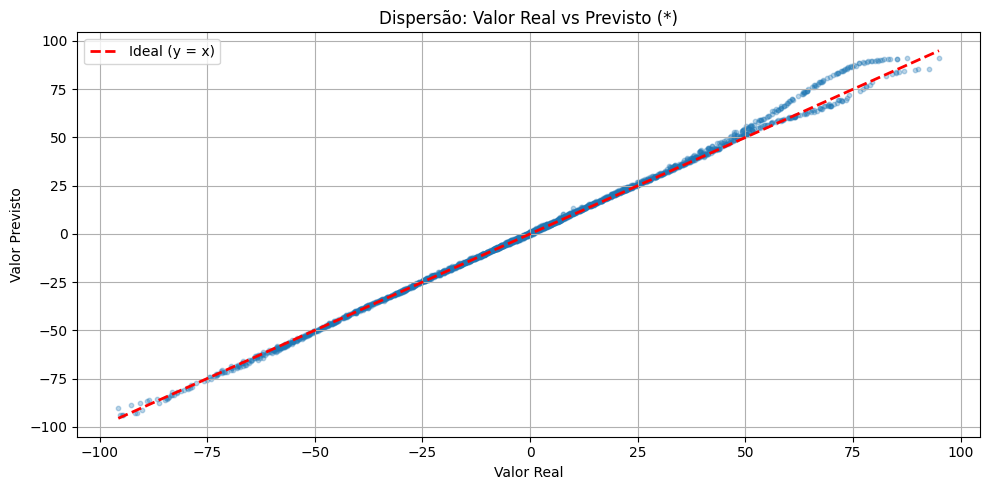

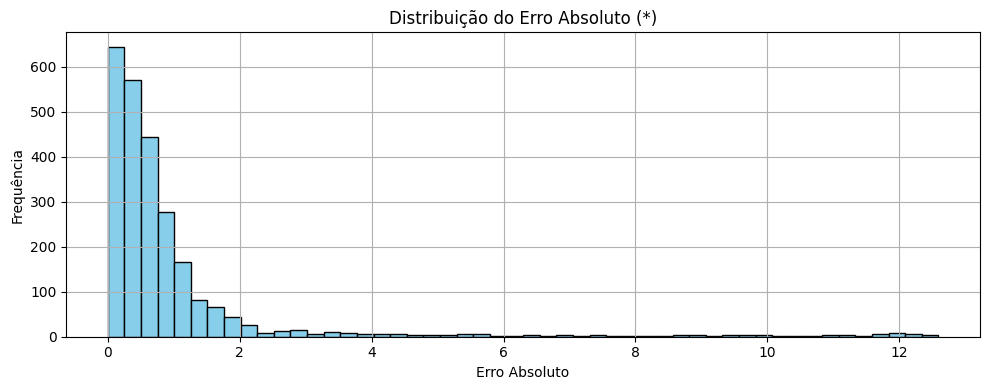

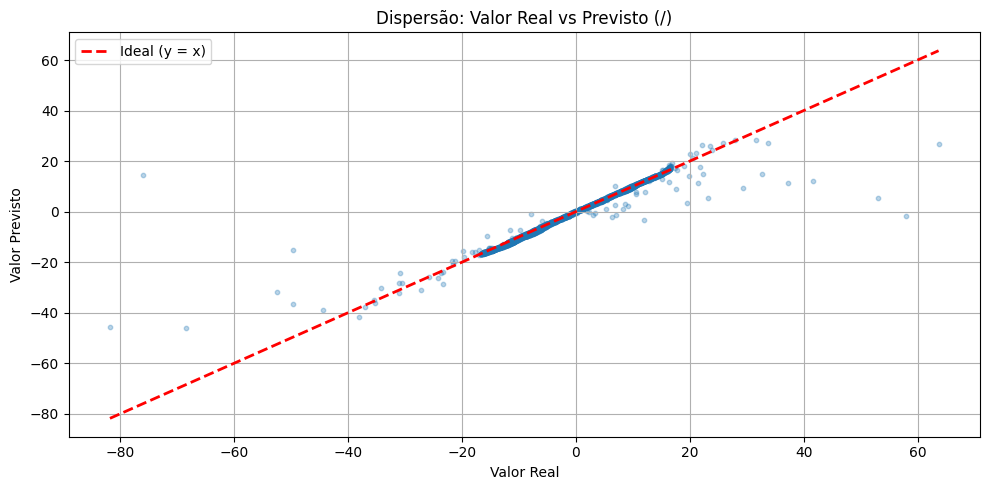

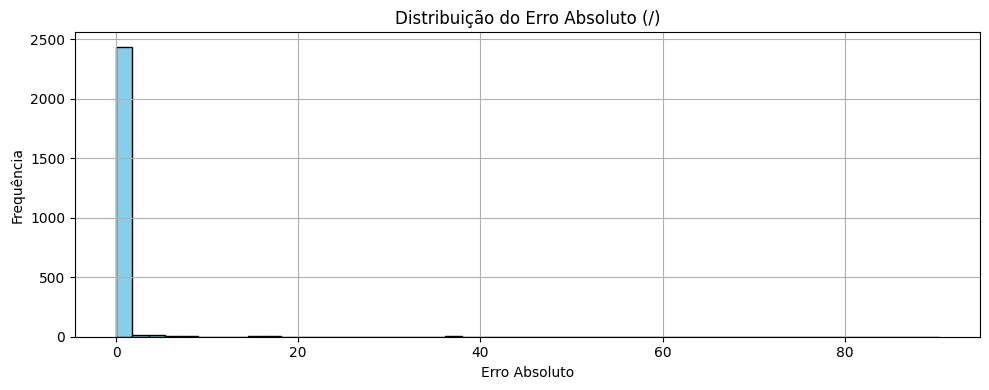

In [22]:
# Gerar 10.000 novas equações aleatórias
df_test = gerar_dataset(n_samples=10000)
df_test_original = df_test.copy()

# Normalizar os dados
df_test[['num1', 'num2']] = scaler_carregado.transform(df_test[['num1', 'num2']])

# Preparar os dados para o modelo
X_manual = df_test[['num1', 'num2', 'operacao_+', 'operacao_-', 'operacao_*', 'operacao_/']].values

# Fazer previsões
df_test_original['previsto'] = modelo_carregado.predict(X_manual).flatten()

# Calcular erro absoluto
df_test_original['erro'] = abs(df_test_original['previsto'] - df_test_original['resultado'])

# Identificar tipo de operação
df_test_original['tipo'] = df_test[['operacao_+', 'operacao_-', 'operacao_*', 'operacao_/']].idxmax(axis=1)
df_test_original['tipo'] = df_test_original['tipo'].str.replace("operacao_", "")

# Listar tipos de operações
tipos_operacoes = df_test_original['tipo'].unique()

# Gráficos por tipo de operação
for op in tipos_operacoes:
    df_op = df_test_original[df_test_original['tipo'] == op]

    # Gráfico de dispersão
    plt.figure(figsize=(10, 5))
    plt.scatter(df_op['resultado'], df_op['previsto'], alpha=0.3, s=10)
    plt.plot([df_op['resultado'].min(), df_op['resultado'].max()],
             [df_op['resultado'].min(), df_op['resultado'].max()],
             color='red', linestyle='--', linewidth=2, label='Ideal (y = x)')
    plt.xlabel('Valor Real')
    plt.ylabel('Valor Previsto')
    plt.title(f'Dispersão: Valor Real vs Previsto ({op})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Histograma do erro absoluto
    plt.figure(figsize=(10, 4))
    plt.hist(df_op['erro'], bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Distribuição do Erro Absoluto ({op})')
    plt.xlabel('Erro Absoluto')
    plt.ylabel('Frequência')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
